**Set up Google Colab**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




*   Change directory to my google drive




In [ ]:
%cd "/content/drive/My Drive/"

/content/drive/My Drive


**Dataset Downloading**


*   First, Clone the repo to my google drive.






In [ ]:
!git clone https://github.com/udacity/dermatologist-ai.git



*   Change directory to the project files:



In [ ]:
%cd /content/drive/My Drive/dermatologist-ai

/content/drive/My Drive/dermatologist-ai




*   create a data/ folder to hold the dataset of skin images


In [ ]:
!mkdir data

In [ ]:
!pwd



*   Download the dataset at dermatologist-ai/data/ using GNU Wget software package for retrieving files using HTTPS protocol.

In [ ]:
!wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip
!wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip
!wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip


*   Extract the zip files

In [ ]:
!unzip train.zip 
!unzip test.zip 
!unzip valid.zip



*   Delete the zip files because we won't need it again

In [ ]:
!rm "/content/drive/My Drive/dermatologist-ai/train.zip"
!rm "/content/drive/My Drive/dermatologist-ai/valid.zip"
!rm "/content/drive/My Drive/dermatologist-ai/test.zip"


*   Move train,test and valid folders to data/ folder

In [ ]:
!mv "/content/drive/My Drive/dermatologist-ai/train" "/content/drive/My Drive/dermatologist-ai/data/"
!mv "/content/drive/My Drive/dermatologist-ai/test" "/content/drive/My Drive/dermatologist-ai/data/"
!mv "/content/drive/My Drive/dermatologist-ai/valid" "/content/drive/My Drive/dermatologist-ai/data/"

**Import libraries**

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
from collections import OrderedDict

from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

**Specify Data Loaders**

In [ ]:
batch_size = 32
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(299),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([ transforms.Resize(299),
                                      transforms.CenterCrop(299),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder('data/train/', transform=train_transforms)
valid_data = datasets.ImageFolder('data/valid/', transform=train_transforms)
test_data = datasets.ImageFolder('data/test/', transform=test_transforms)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data,batch_size=batch_size,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=False)

classes = ['melanoma','nevus','seborrheic_keratosis']

In [ ]:
print('train data: ', len(train_data))
print('test data: ', len(test_data))
print('valid data: ', len(valid_data))

train data:  2000
test data:  600
valid data:  150


**Visualize images**

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

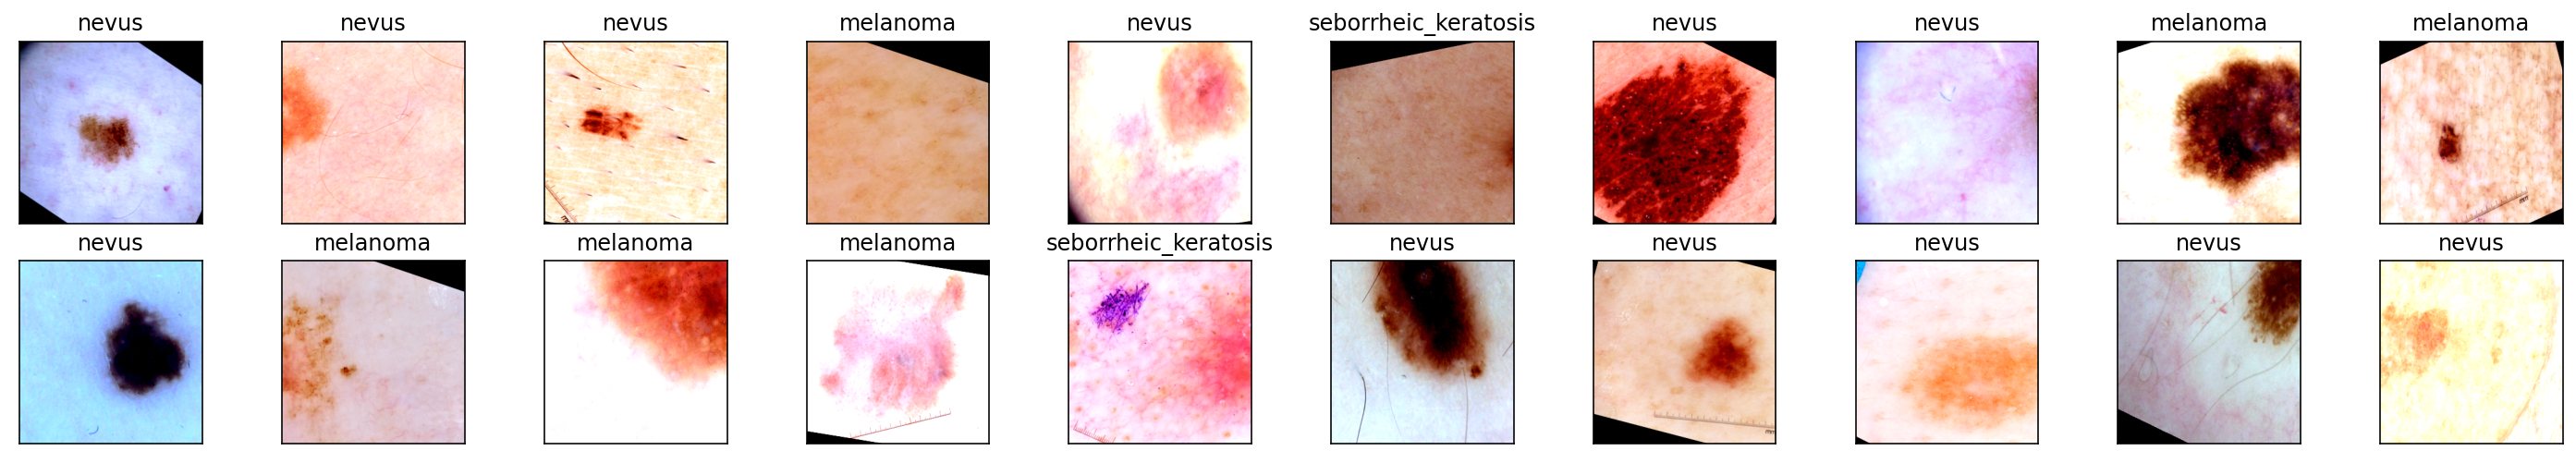

In [ ]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

**Check model architecture for transfer learning**

In [ ]:
model = models.resnet50(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

**Build Model**

In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch

model = models.resnet50(pretrained=True)

for param in model.parameters():
  param.require_grad = False

model.fc =nn.Sequential(nn.Linear(2048, 500),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(500, 3))
#Check if CUDA is avaliable
use_cuda = torch.cuda.is_available()

if not use_cuda:
    print('CUDA is Not avaliable. Taining on CPU')
else:
    print('CUDA is avaliable . Training on GPU')

if use_cuda:
  model = model.cuda()

CUDA is avaliable . Training on GPU


**Specify Loss Function and Optimizer**

In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

**Train and Validate the Model**

In [ ]:
def train(n_epochs, train_loader, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            
            #1.clear the gradients of all optimized variables
            optimizer.zero_grad()
            #2.forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            #3.calculate the batch loss
            loss = criterion(output, target)
            #4.backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            #5.perform a single optimization step (parameter update)
            optimizer.step()
            #6.update training loss
            #train_loss+=loss.item()*data.size(0)
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(valid_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            #1.forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            #2.calculate the batch loss
            loss = criterion(output, target)
            #3.update average validation loss 
            #valid_loss+=loss.item()*data.size(0)
            valid_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(),save_path)
            valid_loss_min = valid_loss
    # return trained model
    return model

In [ ]:
# train the model
model = train(20, train_loader, model, optimizer, criterion, use_cuda, 'dermatologist_ai_model.pt')

Epoch: 1 	Training Loss: 1.035610 	Validation Loss: 1.045908
Validation loss decreased (inf --> 1.045908).  Saving model ...
Epoch: 2 	Training Loss: 0.981856 	Validation Loss: 1.024527
Validation loss decreased (1.045908 --> 1.024527).  Saving model ...
Epoch: 3 	Training Loss: 0.940610 	Validation Loss: 1.007529
Validation loss decreased (1.024527 --> 1.007529).  Saving model ...
Epoch: 4 	Training Loss: 0.911307 	Validation Loss: 1.000115
Validation loss decreased (1.007529 --> 1.000115).  Saving model ...
Epoch: 5 	Training Loss: 0.889665 	Validation Loss: 0.997088
Validation loss decreased (1.000115 --> 0.997088).  Saving model ...
Epoch: 6 	Training Loss: 0.876544 	Validation Loss: 0.995529
Validation loss decreased (0.997088 --> 0.995529).  Saving model ...
Epoch: 7 	Training Loss: 0.861803 	Validation Loss: 0.996255
Epoch: 8 	Training Loss: 0.854262 	Validation Loss: 1.002165
Epoch: 9 	Training Loss: 0.851446 	Validation Loss: 1.003421
Epoch: 10 	Training Loss: 0.843830 	Valida

**Evaluate model**

**Load the model**

In [ ]:
# load the model that got the best validation accuracy
model.load_state_dict(torch.load('dermatologist_ai_model.pt'))

<All keys matched successfully>

**Test the model**

In [ ]:
def test(test_loader, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(test_loader):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [ ]:
# call test function    
test(test_loader, model, criterion, use_cuda)

Test Loss: 0.912203


Test Accuracy: 65% (393/600)


In [ ]:
import glob 
import cv2

test_dir = ["data/test/melanoma", 
              "data/test/nevus",
              "data/test/seborrheic_keratosis"]

def get_images_paths(directory):
  img_paths = []
  for i in range(3):
    # cont = 1
    for file in glob.glob(directory[i]+"/*.jpg"):
      img_paths.append(file)    
  return img_paths

img_paths = get_images_paths(test_dir)
print(len(img_paths))
print("first five: ", img_paths[:5], "\nMiddle five: ", img_paths[300:305], "\nLast five: ", img_paths[-5:])

600
first five:  ['data/test/melanoma/ISIC_0012258.jpg', 'data/test/melanoma/ISIC_0012356.jpg', 'data/test/melanoma/ISIC_0013457.jpg', 'data/test/melanoma/ISIC_0012395.jpg', 'data/test/melanoma/ISIC_0013277.jpg'] 
Middle five:  ['data/test/nevus/ISIC_0015226.jpg', 'data/test/nevus/ISIC_0015223.jpg', 'data/test/nevus/ISIC_0015224.jpg', 'data/test/nevus/ISIC_0015232.jpg', 'data/test/nevus/ISIC_0015208.jpg'] 
Last five:  ['data/test/seborrheic_keratosis/ISIC_0014588.jpg', 'data/test/seborrheic_keratosis/ISIC_0014500.jpg', 'data/test/seborrheic_keratosis/ISIC_0014629.jpg', 'data/test/seborrheic_keratosis/ISIC_0014590.jpg', 'data/test/seborrheic_keratosis/ISIC_0014587.jpg']


**Save image paths to text file**

In [ ]:
with open("ordered_paths.txt", "w") as txt_file:
    for line in img_paths:
        txt_file.write("".join(line) + "\n")

**Get predictions**

In [ ]:
img_paths = [line.rstrip('\n') for line in open('ordered_paths.txt')] 

print(len(img_paths))
print(img_paths[0])

600
data/test/melanoma/ISIC_0012258.jpg


In [ ]:
print("first five: ", img_paths[:5], "\nMiddle five: ", img_paths[300:305], "\nLast five: ", img_paths[-5:])

first five:  ['data/test/melanoma/ISIC_0012258.jpg', 'data/test/melanoma/ISIC_0012356.jpg', 'data/test/melanoma/ISIC_0013457.jpg', 'data/test/melanoma/ISIC_0012395.jpg', 'data/test/melanoma/ISIC_0013277.jpg'] 
Middle five:  ['data/test/nevus/ISIC_0015226.jpg', 'data/test/nevus/ISIC_0015223.jpg', 'data/test/nevus/ISIC_0015224.jpg', 'data/test/nevus/ISIC_0015232.jpg', 'data/test/nevus/ISIC_0015208.jpg'] 
Last five:  ['data/test/seborrheic_keratosis/ISIC_0014588.jpg', 'data/test/seborrheic_keratosis/ISIC_0014500.jpg', 'data/test/seborrheic_keratosis/ISIC_0014629.jpg', 'data/test/seborrheic_keratosis/ISIC_0014590.jpg', 'data/test/seborrheic_keratosis/ISIC_0014587.jpg']


In [ ]:
import numpy as np
from PIL import Image

def load_image(path):
  image = Image.open(path)
  image = test_transforms(image)
  image = torch.tensor(image, requires_grad=True)
  image = image.unsqueeze(0)
  return image

def get_predictions(img_paths):
  """ Is melanoma? """
  pred_rank1 = [] # Is melanoma?
  pred_rank2 = [] # Is seborrheic?
  for img_path in img_paths:
    img = load_image(img_path)
    #img.to(device)
    prediction = model(img)
    #img.to("cpu")
    pred_rank1.append(float(prediction.data[0][0]))
    pred_rank2.append(float(prediction.data[0][2]))
  return pred_rank1, pred_rank2

model.to("cpu")
model.eval()
print("")

In [ ]:
task1, task2 = get_predictions(img_paths)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


In [ ]:
print("Task 1 predictions: ", len(task1))
print("first five predictions (Task 1): ", task1[:5])

print("Task 2 predictions: ", len(task2))
print("first five predictions (Task 2): ", task2[:5])

Task 1 predictions:  600
first five predictions (Task 1):  [-0.3778006434440613, -0.2079073190689087, -0.28720951080322266, -0.40337613224983215, -0.3019202947616577]
Task 2 predictions:  600
first five predictions (Task 2):  [-0.39865827560424805, -0.2004576474428177, -0.29062291979789734, -0.46844613552093506, -0.4316890239715576]


In [ ]:
import csv
        
with open('my_results.csv', 'w', newline='') as csvfile:
  doc = csv.writer(csvfile)
  doc.writerow(['Id', 'task_1', 'task_2'])
  for i in range(len(img_paths)):
    doc.writerow([img_paths[i], task1[i], task2[i]])

**Get scores**

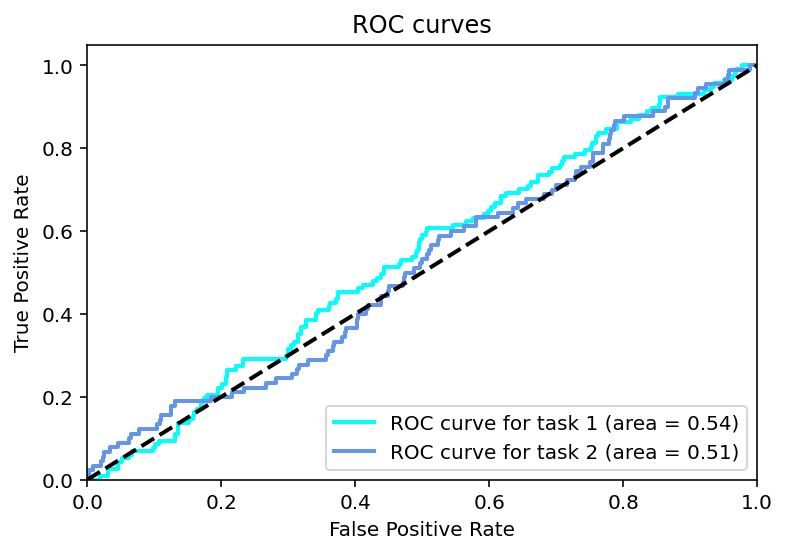

Category 1 Score: 0.537
Category 2 Score: 0.514
Category 3 Score: 0.525


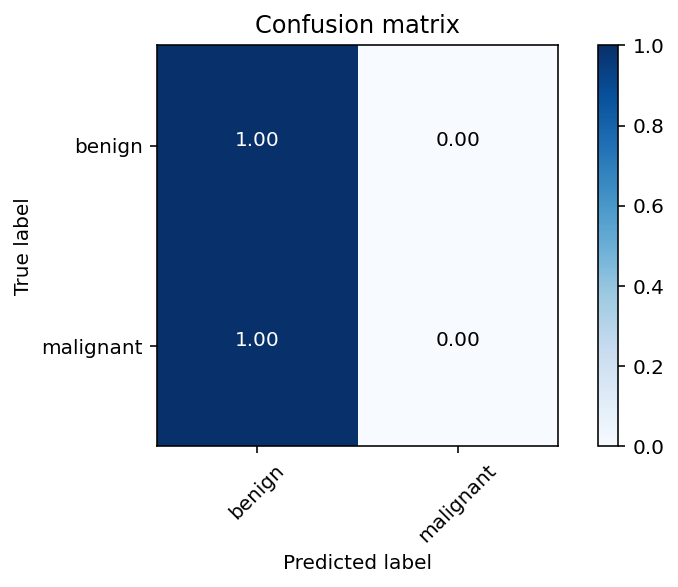

In [ ]:
import pandas as pd
import sys
import itertools
import get_results as results

threshold = 0.5 

# get ground truth labels for test dataset
truth = pd.read_csv('ground_truth.csv')
y_true = truth[["task_1", "task_2"]].values

# get model predictions for test dataset
y_pred = pd.read_csv('my_results.csv')
y_pred = y_pred[["task_1", "task_2"]].values

# plot ROC curves and print scores
results.plot_roc_auc(y_true, y_pred)
# plot confusion matrix
classes = ['benign', 'malignant']
results.plot_confusion_matrix(y_true[:,0], y_pred[:,0], threshold, classes)